## Directory

In [1]:
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
os.chdir("/content/drive/MyDrive/vapaad gifs")

## Library

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

## Acquire Data

In [5]:
%%time

# Download and load the dataset.
fpath = keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)
dataset = np.load(fpath)

# Swap the axes representing the number of frames and number of data samples.
dataset = np.swapaxes(dataset, 0, 1)
# We'll pick out 1000 of the 10000 total examples and use those.
dataset = dataset[:1000, ...]
# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)

# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255


# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y


# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)
CPU times: user 141 ms, sys: 1.86 s, total: 2.01 s
Wall time: 1.99 s


### Visualization

Displaying frames for example 825.


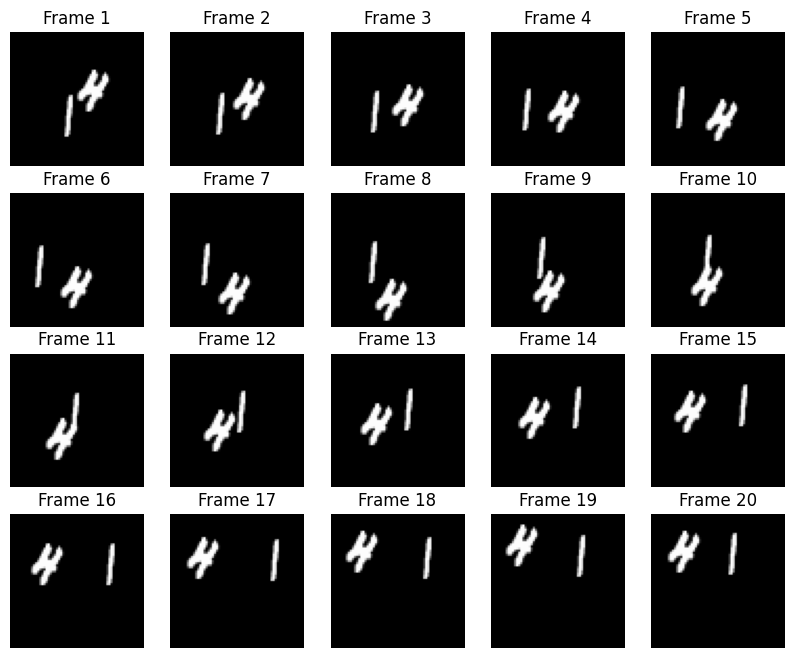

CPU times: user 1.23 s, sys: 251 ms, total: 1.48 s
Wall time: 1.25 s


In [6]:
%%time

# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [7]:
import matplotlib.pyplot as plt

def plot_image_sequences(x_train, y_train, num_samples=5):
    """
    Plots sequences of input and output images for a number of samples, with titles.

    Args:
    x_train (np.ndarray): Input image sequences.
    y_train (np.ndarray): Output image sequences.
    num_samples (int): Number of samples to plot.
    """
    fig, axes = plt.subplots(num_samples, 38, figsize=(38, num_samples * 2))  # Adjusted figsize for title space
    fig.suptitle("Sample Input/Output Sequence Images from Moving MNIST", fontsize=25, y=1.05)
    plt.figtext(0.5, 1.01, "First 19 frames are input sequences whereas latter 19 frames are output sequences",
                ha='center', fontsize=25, va='top')

    for i in range(num_samples):
        for j in range(19):  # Plot input images
            axes[i, j].imshow(x_train[i, j, :, :, 0], cmap='gray')
            axes[i, j].set_title(f'Frame {j + 1}', fontsize=8)
            axes[i, j].axis('off')
        for j in range(19):  # Plot output images
            axes[i, j + 19].imshow(y_train[i, j, :, :, 0], cmap='gray')
            axes[i, j + 19].set_title(f'Frame {j + 20}', fontsize=8)
            axes[i, j + 19].axis('off')

    plt.tight_layout()
    plt.show()

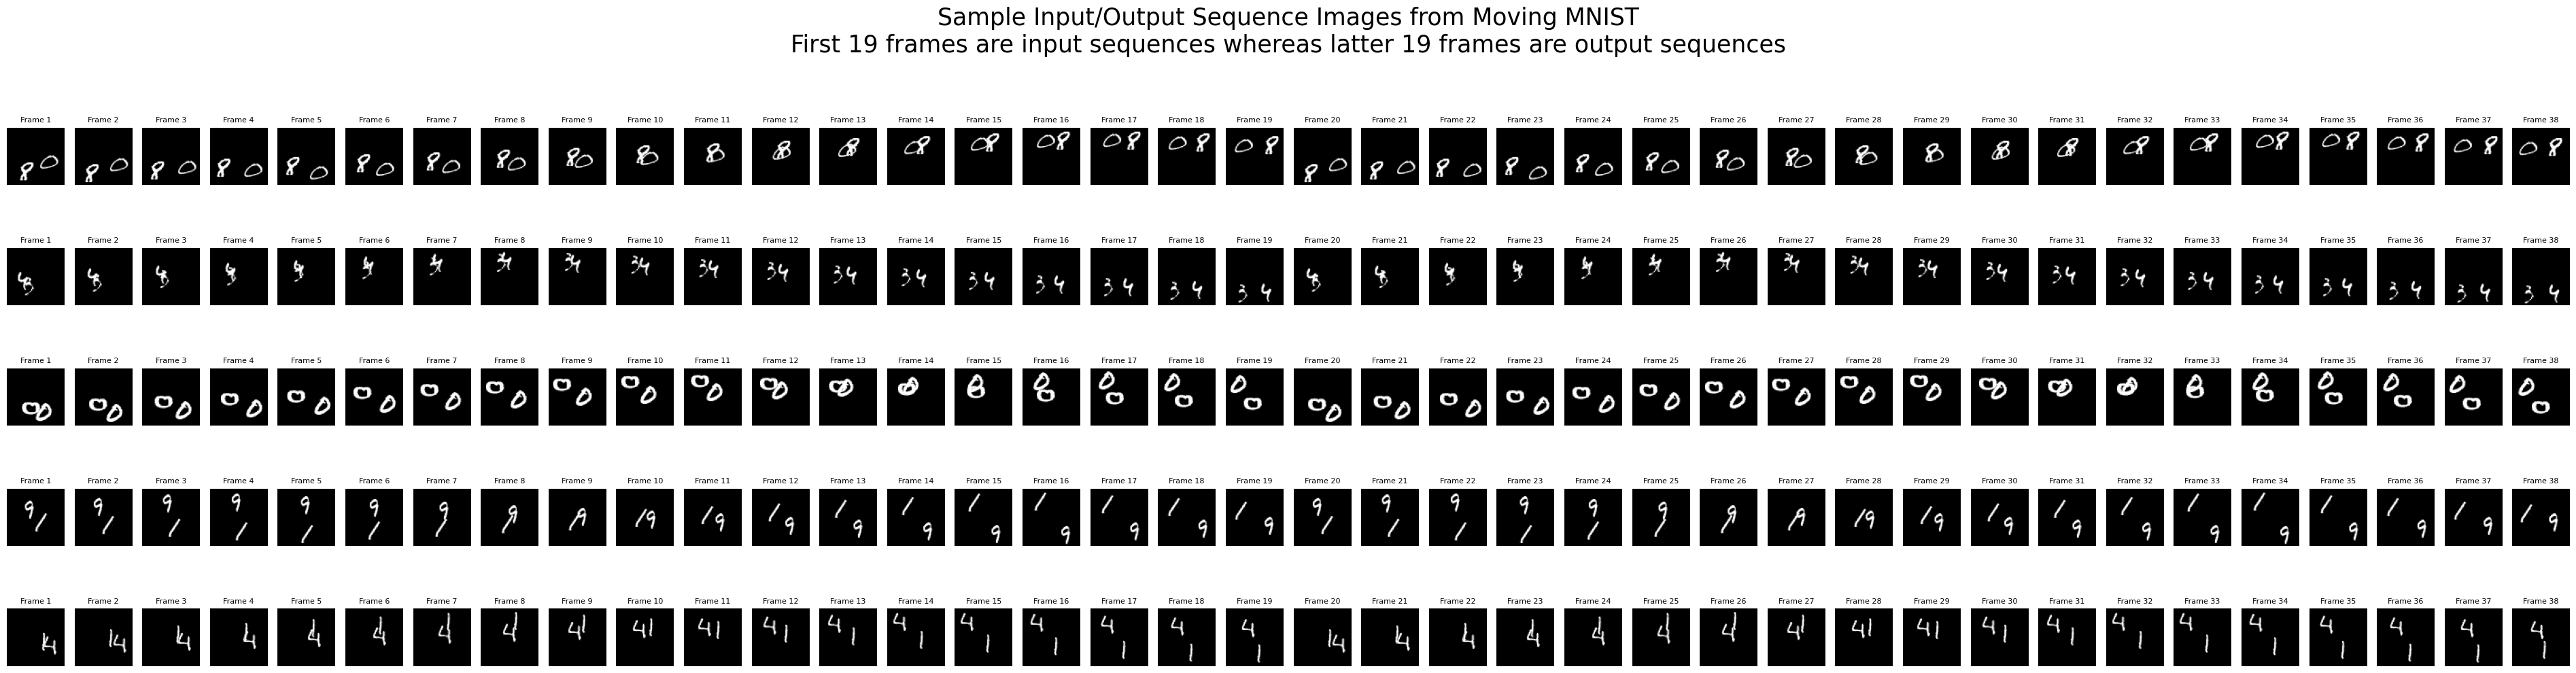

CPU times: user 12.2 s, sys: 403 ms, total: 12.6 s
Wall time: 12.2 s


In [8]:
%%time

# Example usage
plot_image_sequences(x_train, y_train)

## Build `VAPAAD` Model

In [6]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from typing import Tuple

class SelfAttention(layers.Layer):
    """
    A custom self-attention layer that computes attention scores to enhance model performance by focusing on relevant parts of the input data.

    This layer creates query, key, and value representations of the input, then calculates attention scores to determine how much focus to put on each part of the input data. The output is a combination of the input and the attention mechanism's weighted focus, which allows the model to pay more attention to certain parts of the data.

    Attributes:
        query_dense (keras.layers.Dense): A dense layer for transforming the input into a query tensor.
        key_dense (keras.layers.Dense): A dense layer for transforming the input into a key tensor.
        value_dense (keras.layers.Dense): A dense layer for transforming the input into a value tensor.
        combine_heads (keras.layers.Dense): A dense layer for combining the attention heads' outputs.
    """

    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape: Tuple[int, ...]):
        """
        Initializes the internal dense layers based on the last dimension of the input shape, setting up the query, key, value, and combine heads layers.

        Args:
            input_shape (Tuple[int, ...]): The shape of the input tensor to the layer.
        """
        self.query_dense = layers.Dense(units=input_shape[-1])
        self.key_dense = layers.Dense(units=input_shape[-1])
        self.value_dense = layers.Dense(units=input_shape[-1])
        self.combine_heads = layers.Dense(units=input_shape[-1])

    def call(self, inputs: tf.Tensor) -> tf.Tensor:
        """
        Performs the self-attention mechanism on the input tensor and returns the combined output with a residual connection.

        Args:
            inputs (tf.Tensor): The input tensor to the self-attention layer.

        Returns:
            tf.Tensor: The output tensor after applying self-attention and combining with the input tensor through a residual connection.
        """
        # Generate query, key, value tensors
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # Calculate attention scores
        scores = tf.matmul(query, key, transpose_b=True)
        distribution = tf.nn.softmax(scores)
        attention_output = tf.matmul(distribution, value)

        # Combine heads and add residual connection
        combined_output = self.combine_heads(attention_output) + inputs
        return combined_output

In [7]:
from typing import Tuple
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

def vapaad(input_shape: Tuple[int, int, int], image_size: int = 64) -> keras.Model:
    """
    Builds a video processing model with data augmentation and self-attention mechanisms.

    Args:
        input_shape (Tuple[int, int, int]): The shape of the input frames.
        image_size (int, optional): The target size to resize the frames. Defaults to 64.

    Returns:
        keras.Model: A compiled keras model ready for training.
    """
    # Initialize the data augmentation pipeline
    data_augmentation = keras.Sequential([
        # layers.RandomFlip("horizontal"),  # Randomly flip frames horizontally
        # layers.RandomRotation(factor=0.02),  # Randomly rotate frames by a small angle
        layers.RandomZoom(height_factor=0.01, width_factor=0.01),  # Randomly zoom in on frames
    ], name="data_augmentation")

    inp = layers.Input(shape=input_shape)  # Define the input layer with the specified shape

    # Apply data augmentation to each frame using the TimeDistributed layer
    x = layers.TimeDistributed(data_augmentation)(inp)

    # First ConvLSTM2D layer with self-attention
    x = layers.ConvLSTM2D(filters=64, kernel_size=(5, 5), padding="same", return_sequences=True, activation="relu")(x)
    x = layers.BatchNormalization()(x)  # Normalize the activations of the first layer
    x = SelfAttention()(x)  # Apply self-attention mechanism

    # Second ConvLSTM2D layer with self-attention
    x = layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding="same", return_sequences=True, activation="relu")(x)
    x = layers.BatchNormalization()(x)  # Normalize the activations of the second layer
    x = SelfAttention()(x)  # Apply self-attention mechanism

    # Third ConvLSTM2D layer with self-attention
    x = layers.ConvLSTM2D(filters=64, kernel_size=(1, 1), padding="same", return_sequences=True, activation="relu")(x)
    x = SelfAttention()(x)  # Apply self-attention mechanism

    # Final Conv3D layer to produce the output
    x = layers.Conv3D(filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same")(x)

    # Create the model
    model = keras.models.Model(inputs=inp, outputs=x)

    # Return
    return model

### Define Generators

In [8]:
# Example usage:
# Assuming x_train.shape is (900, 19, 64, 64, 1), indicating (samples, frames, height, width, channels)
gen_past = vapaad(input_shape=(None, *x_train.shape[2:]))
gen_future = vapaad(input_shape=(None, *x_train.shape[2:]))

## Instructor

In [9]:
# Instructor model
def instructor_model(input_shape: Tuple[int, int, int], image_size: int = 64) -> keras.Model:
    """
    Builds a video processing model ending with fully connected layers.

    Args:
        input_shape (Tuple[int, int, int]): The shape of the input frames.
        image_size (int, optional): The target size to resize the frames. Defaults to 64.

    Returns:
        keras.Model: A compiled keras model ready for training with a one-dimensional output.
    """
    # Initialize the data augmentation pipeline
    data_augmentation = keras.Sequential([
        # layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.01, width_factor=0.01),  # Randomly zoom in on frames
    ], name="data_augmentation")

    inp = layers.Input(shape=input_shape)

    # Apply data augmentation to each frame using the TimeDistributed layer
    x = layers.TimeDistributed(data_augmentation)(inp)

    # ConvLSTM2D layers with self-attention
    x = layers.ConvLSTM2D(filters=64, kernel_size=(5, 5), padding="same", return_sequences=True, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = SelfAttention()(x)

    x = layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding="same", return_sequences=True, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = SelfAttention()(x)

    x = layers.ConvLSTM2D(filters=64, kernel_size=(1, 1), padding="same", return_sequences=True, activation="relu")(x)
    x = SelfAttention()(x)

    # Adding global average pooling to reduce the dimensionality before dense layers
    x = layers.GlobalAveragePooling3D()(x)

    # Fully connected dense layers
    x = layers.Dense(2048, activation='relu')(x)
    x = layers.Dense(1024, activation='relu')(x)

    # Final dense layer for one-dimensional output
    output = layers.Dense(1, activation='sigmoid')(x)

    # Create the model
    model = keras.models.Model(inputs=inp, outputs=output)

    return model

### Define Instructor

In [10]:
# Example usage:
# Assuming x_train.shape is (900, 19, 64, 64, 1), indicating (samples, frames, height, width, channels)
instructor = instructor_model(input_shape=(None, *x_train.shape[2:]))

In [11]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [12]:
import tensorflow as tf

def generator_loss(fake_output: tf.Tensor) -> tf.Tensor:
    """
    Calculates the loss for the generator model based on its output for generated (fake) images.

    The loss encourages the generator to produce images that the instructor model classifies as real.
    This is achieved by comparing the generator's output for fake images against a target tensor of ones,
    indicating that the ideal output of the generator would be classified as real by the instructor model.

    Args:
    fake_output (tf.Tensor): The generator model's output logits for generated (fake) images.

    Returns:
    tf.Tensor: The loss for the generator model, encouraging it to generate more realistic images.
    """
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [13]:
import tensorflow as tf

def instructor_loss(real_output: tf.Tensor, fake_output: tf.Tensor) -> tf.Tensor:
    """
    Calculates the loss for the instructor model based on its output for real and generated (fake) images.

    The loss is computed as the sum of the cross-entropy losses for the real and fake outputs. For real images,
    the target is a tensor of ones, and for fake images, the target is a tensor of zeros.

    Args:
    real_output (tf.Tensor): The instructor model's output logits for real images.
    fake_output (tf.Tensor): The instructor model's output logits for generated (fake) images.

    Returns:
    tf.Tensor: The total loss for the instructor model, combining the real and fake loss components.
    """
    # Cross-entropy loss for real images (targets are ones)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # Cross-entropy loss for fake images (targets are zeros)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # Sum of real and fake losses
    total_loss = real_loss + fake_loss
    return total_loss

### Learning Rate (with and without customization)

In [14]:
# define two separate optimizer for the generator and the instructor
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
instructor_optimizer = tf.keras.optimizers.Adam(1e-4)

In [15]:
# import tensorflow as tf

# initial_learning_rate = 0.001
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=1000,
#     decay_rate=0.9,
#     staircase=True
# )

# # define two separate optimizer for the generator and the instructor
# # with learning rate scheduler
# generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# instructor_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

### Define `train_step`

In [15]:
import numpy as np
import tensorflow as tf
import time
from tqdm import tqdm

@tf.function
def train_step(images: tf.Tensor, future_images: tf.Tensor,
               gen_optimizer: tf.keras.optimizers.Optimizer,
               inst_optimizer: tf.keras.optimizers.Optimizer) -> Tuple[tf.Tensor, tf.Tensor]:
    """
    Perform a single training step by updating the generator and instructor models.

    Args:
        images (tf.Tensor): Input images for the generator model `gen_past`.
        future_images (tf.Tensor): Future images for the generator model `gen_future`.
        gen_optimizer (tf.keras.optimizers.Optimizer): Optimizer for the generator model.
        inst_optimizer (tf.keras.optimizers.Optimizer): Optimizer for the instructor model.

    Returns:
        Tuple[tf.Tensor, tf.Tensor]: Tuple containing the generator loss and instructor loss.
    """

    # Use GradientTape to track operations for automatic differentiation.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as inst_tape:
        # Generate outputs from both current and future input images.
        output_main = gen_past(images, training=True)  # Output from gen_past
        output_aux = gen_future(future_images, training=True)  # Output from gen_future

        # Obtain instructor model outputs for both real and generated images.
        real_output = instructor(output_aux, training=True)  # Instructor output for real images
        fake_output = instructor(output_main, training=True)  # Instructor output for generated images

        # Calculate losses for both generator and instructor models.
        gen_loss = generator_loss(fake_output)  # Loss for generator
        inst_loss = instructor_loss(real_output, fake_output)  # Loss for instructor

    # Compute gradients for generator and instructor.
    gradients_of_gen_past = gen_tape.gradient(gen_loss, gen_past.trainable_variables)  # Gradients for gen_past
    gradients_of_instructor = inst_tape.gradient(inst_loss, instructor.trainable_variables)  # Gradients for instructor

    # Apply gradients to the optimizer for updating model weights.
    gen_optimizer.apply_gradients(zip(gradients_of_gen_past, gen_past.trainable_variables))  # Update gen_past weights
    inst_optimizer.apply_gradients(zip(gradients_of_instructor, instructor.trainable_variables))  # Update instructor weights

    # Update the weights of gen_future using a moving average of gen_past weights.
    alpha = 0.001  # Learning rate for the moving average
    for a, b in zip(gen_future.trainable_variables, gen_past.trainable_variables):
        a.assign(alpha * a + (1 - alpha) * b)  # Update gen_future weights

    # Print current loss values for generator and instructor.
    tf.print("Generator Loss:", gen_loss, "; Instructor Loss:", inst_loss)

    # Return the losses for logging or any other purposes.
    return gen_loss, inst_loss

In [16]:
import numpy as np
import tensorflow as tf
import time
from tqdm import tqdm
from typing import Tuple

def train(x_train: np.ndarray, y_train: np.ndarray, epochs: int, batch_size: int = 64) -> None:
    """
    Trains the model for a given number of epochs with specified batch size.

    This function iterates over the entire dataset for a specified number of epochs,
    randomly selecting batches of data to perform training steps. The selection is random
    and without replacement within each epoch, ensuring diverse exposure of data.

    Args:
    x_train (np.ndarray): The input training data.
    y_train (np.ndarray): The target training data.
    epochs (int): The number of times to iterate over the entire dataset.
    batch_size (int, optional): The number of samples per batch of computation. Defaults to 64.

    Returns:
    None
    """
    # Determine the number of samples in the training dataset.
    n_samples = x_train.shape[0]

    # Iterate over the dataset for the specified number of epochs.
    for epoch in range(epochs):
        start = time.time()  # Record the start time of the epoch.
        indices = np.arange(n_samples)  # Create an array of indices corresponding to the dataset.
        np.random.shuffle(indices)  # Shuffle the indices to ensure random batch selection.

        # Iterate over the dataset in batches.
        for i in tqdm(range(0, n_samples, batch_size)):
            selected_indices = np.random.choice(indices, size=batch_size, replace=False)  # Randomly select indices for the batch.
            x_batch = x_train[selected_indices]  # Extract the batch of input data.
            y_batch = y_train[selected_indices]  # Extract the batch of target data.
            # curr_gen_loss, curr_inst_loss = train_step(x_batch, y_batch)  # Perform a training step with the selected batch.
            curr_gen_loss, curr_inst_loss = train_step(x_batch, y_batch, generator_optimizer, instructor_optimizer) # Perform a training step with the selected batch.

            if curr_gen_loss < 0.2:
                break

        # Print the time taken to complete the epoch.
        print(f'Time for epoch {epoch + 1} is {time.time() - start} sec')

In [17]:
# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)


In [18]:
# Check gpu
tf.test.gpu_device_name()

''

In [19]:
# Convert the data to a smaller data type to reduce memory usage
x_train = x_train.astype(np.float16)
y_train = y_train.astype(np.float16)

In [20]:
# Assuming x_train and y_train are already defined and loaded
num_samples = 64
indices = np.random.choice(x_train.shape[0], num_samples, replace=False)
print(indices[0:6])
x_train_sub = x_train[indices]
y_train_sub = y_train[indices]
print(x_train_sub.shape, y_train_sub.shape)

[318  60 610  65 679 323]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


### Training

In [21]:
%%time

# Assuming x_train and y_train are already defined and loaded
num_samples = 32
indices = np.random.choice(x_train.shape[0], num_samples, replace=False)
print(indices[0:6])
x_train_sub = x_train[indices]
y_train_sub = y_train[indices]
print(x_train_sub.shape, y_train_sub.shape)

# Example usage:
if tf.test.gpu_device_name() != '':
    with tf.device('/device:GPU:0'):
        train(x_train_sub, y_train_sub, epochs=1, batch_size=1)
else:
    train(x_train_sub, y_train_sub, epochs=1, batch_size=1)

[833 648  11 131  76 704]
(32, 19, 64, 64, 1) (32, 19, 64, 64, 1)


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Generator Loss: 0.65321517 ; Instructor Loss: 1.38404715


  3%|▎         | 1/32 [01:12<37:41, 72.96s/it]

Generator Loss: 0.646032 ; Instructor Loss: 1.38756359


  6%|▋         | 2/32 [01:23<18:00, 36.02s/it]

Generator Loss: 0.710444033 ; Instructor Loss: 1.38368702


  9%|▉         | 3/32 [01:33<11:39, 24.13s/it]

Generator Loss: 0.705363154 ; Instructor Loss: 1.38712645


 12%|█▎        | 4/32 [01:43<08:41, 18.63s/it]

Generator Loss: 0.679628253 ; Instructor Loss: 1.38438642


 16%|█▌        | 5/32 [01:53<06:58, 15.49s/it]

Generator Loss: 0.700626493 ; Instructor Loss: 1.38811457


 19%|█▉        | 6/32 [02:02<05:50, 13.49s/it]

Generator Loss: 0.686327755 ; Instructor Loss: 1.38389349


 22%|██▏       | 7/32 [02:13<05:10, 12.41s/it]

Generator Loss: 0.711135268 ; Instructor Loss: 1.38536596


 25%|██▌       | 8/32 [02:22<04:39, 11.63s/it]

Generator Loss: 0.688248515 ; Instructor Loss: 1.38782787


 28%|██▊       | 9/32 [02:32<04:11, 10.91s/it]

Generator Loss: 0.641400099 ; Instructor Loss: 1.38517404


 31%|███▏      | 10/32 [02:42<03:52, 10.56s/it]

Generator Loss: 0.675744772 ; Instructor Loss: 1.37889886


 34%|███▍      | 11/32 [02:52<03:42, 10.59s/it]

Generator Loss: 0.672848403 ; Instructor Loss: 1.38553715


 38%|███▊      | 12/32 [03:02<03:29, 10.47s/it]

Generator Loss: 0.722554743 ; Instructor Loss: 1.39831281


 41%|████      | 13/32 [03:12<03:14, 10.25s/it]

Generator Loss: 0.782149136 ; Instructor Loss: 1.3992399


 44%|████▍     | 14/32 [03:22<03:01, 10.06s/it]

Generator Loss: 0.747297585 ; Instructor Loss: 1.38975668


 47%|████▋     | 15/32 [03:31<02:47,  9.85s/it]

Generator Loss: 0.74630934 ; Instructor Loss: 1.36878848


 50%|█████     | 16/32 [03:41<02:36,  9.78s/it]

Generator Loss: 0.644776642 ; Instructor Loss: 1.38968205


 53%|█████▎    | 17/32 [03:50<02:25,  9.71s/it]

Generator Loss: 0.612874 ; Instructor Loss: 1.38882053


 56%|█████▋    | 18/32 [03:59<02:13,  9.52s/it]

Generator Loss: 0.568870246 ; Instructor Loss: 1.42041659


 59%|█████▉    | 19/32 [04:09<02:04,  9.55s/it]

Generator Loss: 0.60646069 ; Instructor Loss: 1.41107154


 62%|██████▎   | 20/32 [04:19<01:54,  9.57s/it]

Generator Loss: 0.750718355 ; Instructor Loss: 1.3797518


 66%|██████▌   | 21/32 [04:28<01:44,  9.52s/it]

Generator Loss: 0.787211061 ; Instructor Loss: 1.40942681


 69%|██████▉   | 22/32 [04:38<01:35,  9.51s/it]

Generator Loss: 0.781499863 ; Instructor Loss: 1.39172709


 72%|███████▏  | 23/32 [04:47<01:25,  9.52s/it]

Generator Loss: 0.750560164 ; Instructor Loss: 1.36059988


 75%|███████▌  | 24/32 [04:56<01:15,  9.45s/it]

Generator Loss: 0.688599586 ; Instructor Loss: 1.41744149


 78%|███████▊  | 25/32 [05:06<01:06,  9.49s/it]

Generator Loss: 0.646433532 ; Instructor Loss: 1.37136292


 81%|████████▏ | 26/32 [05:15<00:56,  9.43s/it]

Generator Loss: 0.591721356 ; Instructor Loss: 1.39823294


 84%|████████▍ | 27/32 [05:25<00:47,  9.42s/it]

Generator Loss: 0.669672 ; Instructor Loss: 1.40891886


 88%|████████▊ | 28/32 [05:34<00:37,  9.47s/it]

Generator Loss: 0.670749784 ; Instructor Loss: 1.40219092


 91%|█████████ | 29/32 [05:43<00:28,  9.40s/it]

Generator Loss: 0.709772766 ; Instructor Loss: 1.41366267


 94%|█████████▍| 30/32 [05:53<00:18,  9.48s/it]

Generator Loss: 0.696537375 ; Instructor Loss: 1.42034018


 97%|█████████▋| 31/32 [06:03<00:09,  9.51s/it]

Generator Loss: 0.785571098 ; Instructor Loss: 1.40107775


100%|██████████| 32/32 [06:12<00:00, 11.64s/it]

Time for epoch 1 is 372.4312620162964 sec
CPU times: user 37min 29s, sys: 1min 22s, total: 38min 52s
Wall time: 6min 12s


## Prediction

In [22]:
%%time

# prediction on validation set
y_val_pred = gen_past.predict(x_val)

print("Shape of true y_val:", y_val.shape)
print("Shape of predicted y_val:", y_val_pred.shape)

4/4 [==============================] - 97s 21s/step
Shape of true y_val: (100, 19, 64, 64, 1)
Shape of predicted y_val: (100, 19, 64, 64, 1)
CPU times: user 8min 29s, sys: 1min 1s, total: 9min 31s
Wall time: 1min 37s


In [23]:
import numpy as np

def rescale_and_discretize(image):
    """
    Rescales an image to the 0-1 range and discretizes the values into levels {0.1, 0.2, ..., 0.9}.

    Args:
    image (np.ndarray): The input image to be rescaled and discretized.

    Returns:
    np.ndarray: The rescaled and discretized image.
    """
    # Rescale image to 0-1 range
    min_val = np.min(image)
    max_val = np.max(image)
    normalized_image = (image - min_val) / (max_val - min_val) if max_val > min_val else image

    # Discretize to nearest levels in {0.1, 0.2, ..., 0.9}
    levels = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    discretized_image = np.round(normalized_image * 9) / 10  # Multiplies by 9, rounds, then divides by 10
    discretized_image = np.clip(discretized_image, 0.1, 0.9)  # Ensures values are within the specified levels

    return discretized_image

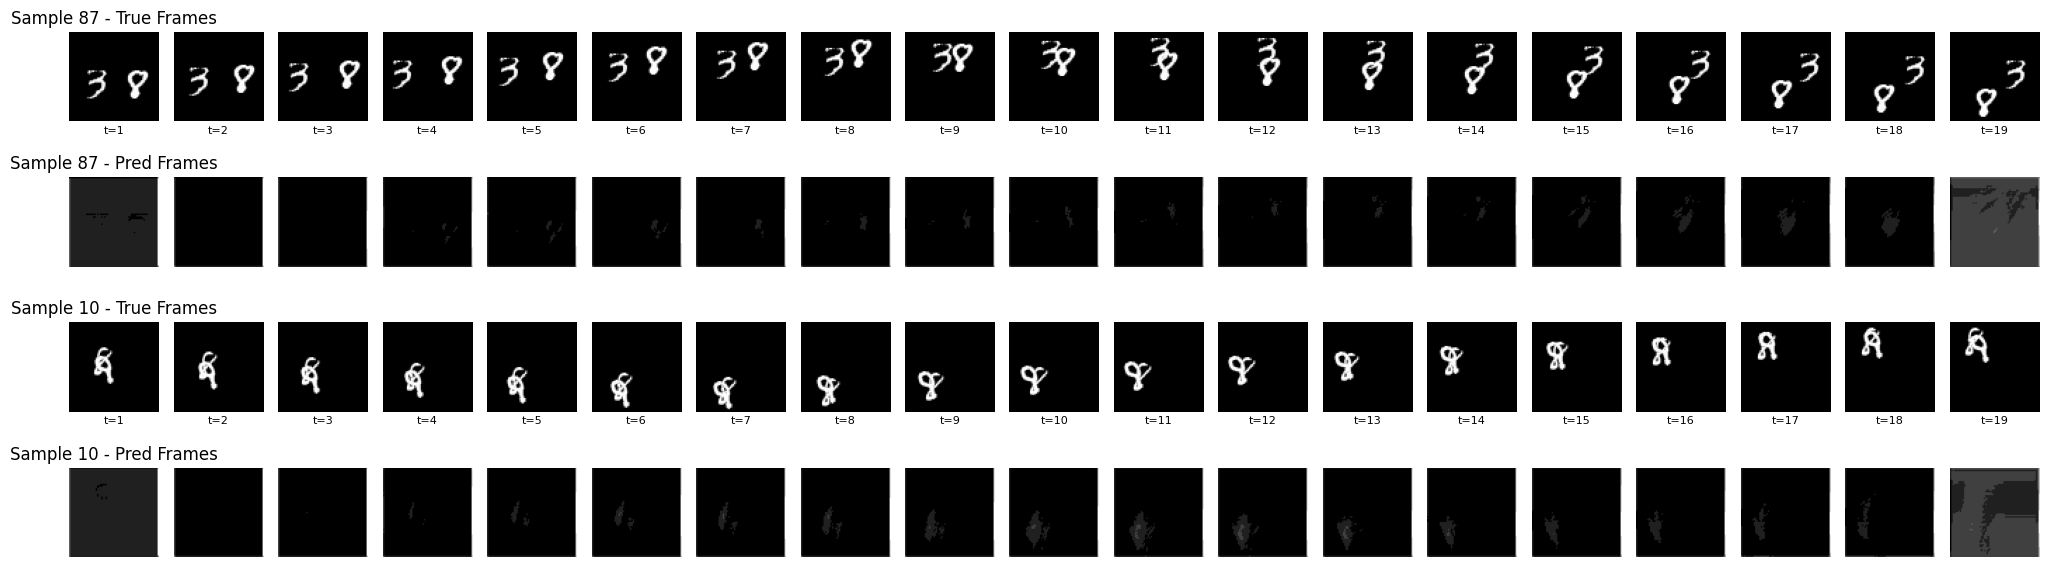

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the figure with specified dimensions
plt.figure(figsize=(20, 6))

# Randomly select 5 samples
num_samples = 2
indices = np.random.choice(y_val.shape[0], num_samples, replace=False)

# Total number of plots per sample (19 predictions + 19 actuals)
num_plots_per_sample = 19 * 2  # 19 predicted and 19 actual

# Iterate over each of the randomly selected samples
for idx, sample_index in enumerate(indices):
    # First row for y_val (true values)
    for i in range(19):
        ax = plt.subplot(num_samples * 2, 19, 2 * idx * 19 + i + 1)  # Calculate position index
        plt.imshow(y_val[sample_index, i, :, :, 0], cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(f'Sample {sample_index+1} - True Frames')
        plt.text(0.5, -0.1, f't={i+1}', ha='center', va='center', transform=ax.transAxes, fontsize=8)  # Adding time label

    # Second row for y_val_pred (predicted values)
    for i in range(19):
        plt.subplot(num_samples * 2, 19, (2 * idx + 1) * 19 + i + 1)  # Calculate position index
        image = y_val_pred[sample_index, i, :, :, 0]
        result_image = rescale_and_discretize(image)
        plt.imshow(result_image, cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(f'Sample {sample_index+1} - Pred Frames')

plt.tight_layout()
plt.show()

In [26]:
# Example usage with an image y_val_pred[sample_index, i, :, :, 0]
# Assuming y_val_pred[sample_index, i, :, :, 0] is your input image:
image = y_val_pred[sample_index, i, :, :, 0]
result_image = rescale_and_discretize(image)
print("Shape:", result_image.shape)
print("Min:", result_image.min())
print("Max:", result_image.max())

Shape: (64, 64)
Min: 0.1
Max: 0.9


### Brute Force

In [ ]:
%%time

for j in range(100):

    # Assuming x_train and y_train are already defined and loaded
    num_samples = 32
    indices = np.random.choice(x_train.shape[0], num_samples, replace=False)
    print(indices[0:6])
    x_train_sub = x_train[indices]
    y_train_sub = y_train[indices]
    print(x_train_sub.shape, y_train_sub.shape)

    # Example usage:
    if tf.test.gpu_device_name() != '':
        with tf.device('/device:GPU:0'):
            train(x_train_sub, y_train_sub, epochs=1, batch_size=1)
    else:
        train(x_train_sub, y_train_sub, epochs=1, batch_size=1)


    # prediction on validation set
    y_val_pred = gen_past.predict(x_val)

    print("Shape of true y_val:", y_val.shape)
    print("Shape of predicted y_val:", y_val_pred.shape)


    # Set up the figure with specified dimensions
    plt.figure(figsize=(20, 6))

    # Randomly select 5 samples
    num_samples = 2
    indices = np.random.choice(y_val.shape[0], num_samples, replace=False)

    # Total number of plots per sample (19 predictions + 19 actuals)
    num_plots_per_sample = 19 * 2  # 19 predicted and 19 actual

    # Iterate over each of the randomly selected samples
    for idx, sample_index in enumerate(indices):
        # First row for y_val (true values)
        for i in range(19):
            ax = plt.subplot(num_samples * 2, 19, 2 * idx * 19 + i + 1)  # Calculate position index
            plt.imshow(y_val[sample_index, i, :, :, 0], cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title(f'Sample {sample_index+1} - True Frames')
            plt.text(0.5, -0.1, f't={i+1}', ha='center', va='center', transform=ax.transAxes, fontsize=8)  # Adding time label

        # Second row for y_val_pred (predicted values)
        for i in range(19):
            plt.subplot(num_samples * 2, 19, (2 * idx + 1) * 19 + i + 1)  # Calculate position index
            image = y_val_pred[sample_index, i, :, :, 0]
            result_image = rescale_and_discretize(image)
            plt.imshow(result_image, cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title(f'Sample {sample_index+1} - Pred Frames')

    plt.tight_layout()
    plt.show()

    print(f"... finished with round: {j} ...")

Output hidden; open in https://colab.research.google.com to view.

## Create `.gif`

In [39]:
# Create a directory for the GIFs
gif_dir = "predicted_gifs_instruct_vapaad_stop_grad"
os.makedirs(gif_dir, exist_ok=True)

# Select a few random examples from the dataset.
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# Iterate over the examples and predict the frames.
predicted_videos = []
for index, example in enumerate(examples):
    # Pick the first/last ten frames from the example.
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(10):
        # Extract the generator's prediction and post-process it.
        frames = example[: 10 + i + 1, ...]
        new_prediction = gen_past.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_set_idx, frame_set in enumerate([original_frames, new_predictions]):
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Define the GIF filepath
        gif_filename = os.path.join(gif_dir, f"example_{index}_{'original' if frame_set_idx == 0 else 'predicted'}.gif")

        # Save the GIF
        imageio.mimsave(gif_filename, current_frames, "GIF", duration=0.2)

        # To display the videos inline, you can open and read the saved GIF
        with open(gif_filename, 'rb') as gif_file:
            predicted_videos.append(gif_file.read())

# Display the videos inline in the notebook.
print("Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i], format='gif'),
            widgets.Image(value=predicted_videos[i + 1], format='gif'),
        ]
    )
    display(box)


1/1 [==============================] - 1s 846ms/step
Truth	Prediction
